In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
FOLDERNAME =  "YOUR-PATH-HERE"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME/
!ls

In [ ]:
!pip install -U datasets

In [ ]:
# prompt: load json file to datasets lib

import datasets
from datasets import load_dataset

# Assuming your JSON file is named 'your_file.json' and is located in the same directory
# as your current Colab notebook.  Adjust the path if necessary.
dataset = load_dataset('json', data_files='train.jsonl')
test_dataset = load_dataset('json', data_files='test.jsonl')



Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# prompt: iterate. thought the examples and get the compression, coverage, density values and create a data fame

import pandas as pd

# Assuming 'dataset' is already loaded as in the previous code

compression_values = []
coverage_values = []
density_values = []
compression_bin = []
coverage_bin = []
density_bin = []

for example in dataset['train']:
  try:
    compression_values.append(example['compression'])
    coverage_values.append(example['coverage'])
    density_values.append(example['density'])
    compression_bin.append(example['compression_bin'])
    coverage_bin.append(example['coverage_bin'])
    density_bin.append(example['density_bin'])
  except KeyError as e:
    print(f"Warning: Key {e} not found in example. Skipping this example.")
    # Handle missing keys appropriately, e.g., append NaN values
    compression_values.append(float('nan'))
    coverage_values.append(float('nan'))
    density_values.append(float('nan'))
    compression_bin.append(float('nan'))
    coverage_bin.append(float('nan'))
    density_bin.append(float('nan'))


data = {
    'compression': compression_values,
    'coverage': coverage_values,
    'density': density_values,
    'compression_bin': compression_bin,
    'coverage_bin': coverage_bin,
    'density_bin': density_bin
}

df = pd.DataFrame(data)
df


,compression,coverage,density,compression_bin,coverage_bin,density_bin
0,137.470588,1.000000,7.823529,high,high,mixed
1,33.636364,0.909091,4.727273,medium,medium,mixed
2,33.880000,1.000000,11.720000,medium,high,extractive
3,11.894118,0.988235,38.988235,low,high,extractive
4,3.932584,0.921348,36.629213,low,medium,extractive
...,...,...,...,...,...,...
995036,20.666667,1.000000,45.000000,medium,high,extractive
995037,18.673913,0.369565,0.456522,medium,low,abstractive
995038,12.369565,0.456522,0.456522,low,low,abstractive
995039,18.285714,0.404762,0.404762,medium,low,abstractive


In [ ]:
# prompt: print me unique values of the bin cols

print(df['compression_bin'].unique())
print(df['coverage_bin'].unique())
print(df['density_bin'].unique())


['high' 'medium' 'low']
['high' 'medium' 'low']
['mixed' 'extractive' 'abstractive']


In [ ]:
df.describe()

,compression,coverage,density
count,995041.000000,995041.000000,995041.000000
mean,43.899790,0.825464,9.483132
std,387.771759,0.179454,13.975221
min,0.000000,0.000000,0.000000
25%,12.157895,0.733333,1.218750
50%,24.172414,0.877551,2.666667
75%,43.761905,0.967742,13.388889
max,105559.000000,1.000000,1135.000000


In [ ]:
min_compression = df['compression'].min()
max_compression = df['compression'].max()
min_coverage = df['coverage'].min()
max_coverage = df['coverage'].max()
min_density = df['density'].min()
max_density = df['density'].max()

In [ ]:
print("Min Compression:", min_compression)
print("Max Compression:", max_compression)


In [ ]:
filtered_df = df[df['compression'] < 400]

In [ ]:
filtered_df.shape

(991181, 6)

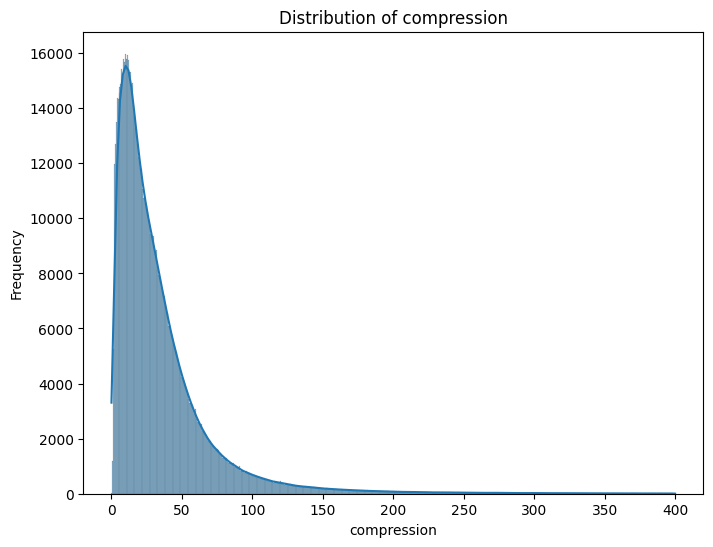

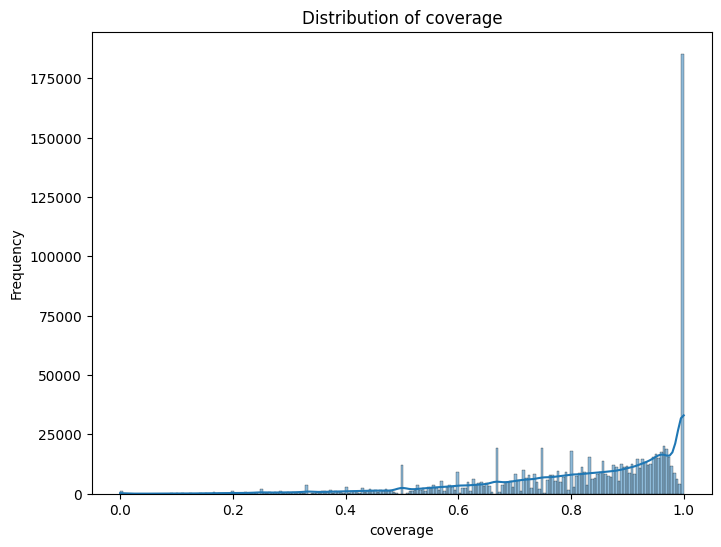

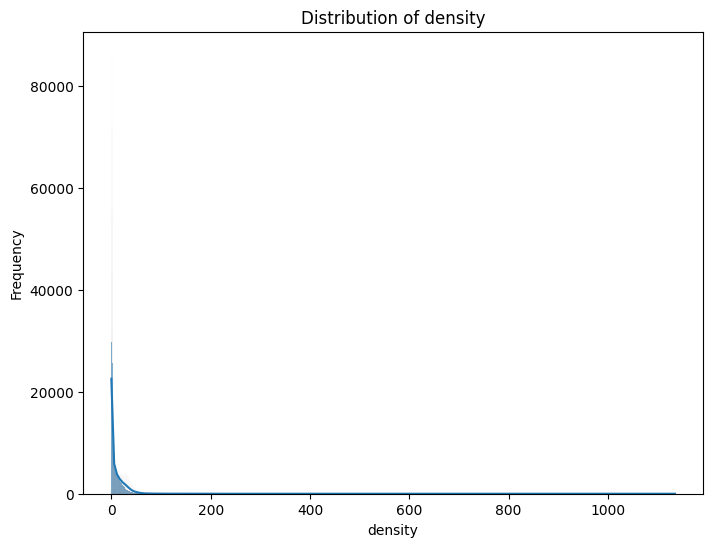

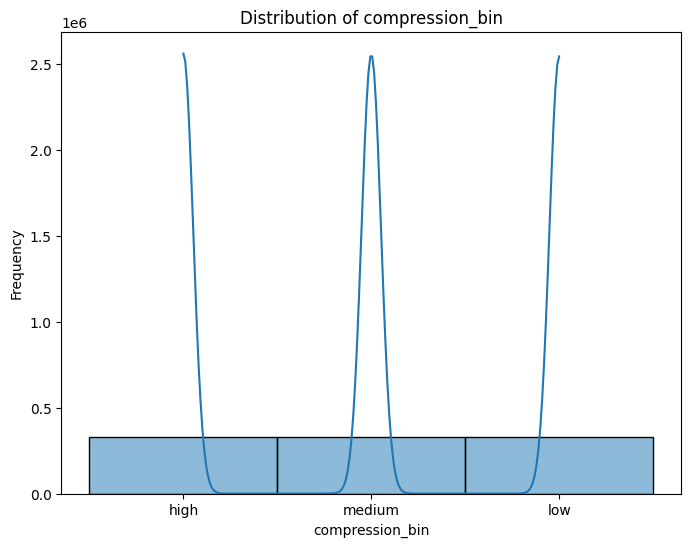

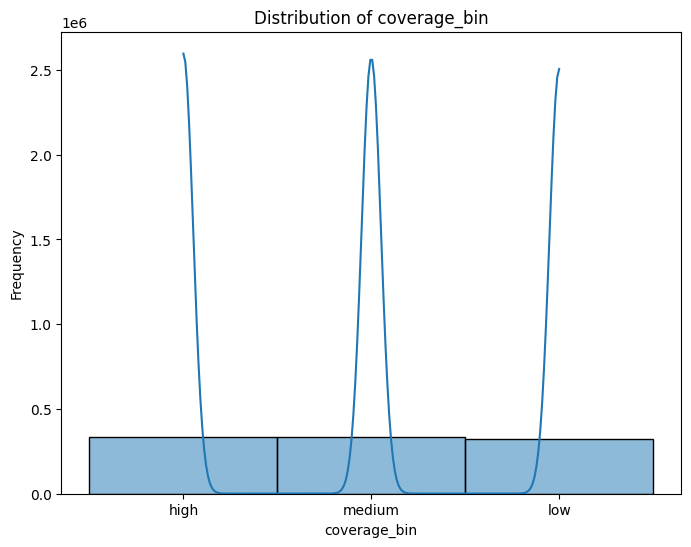

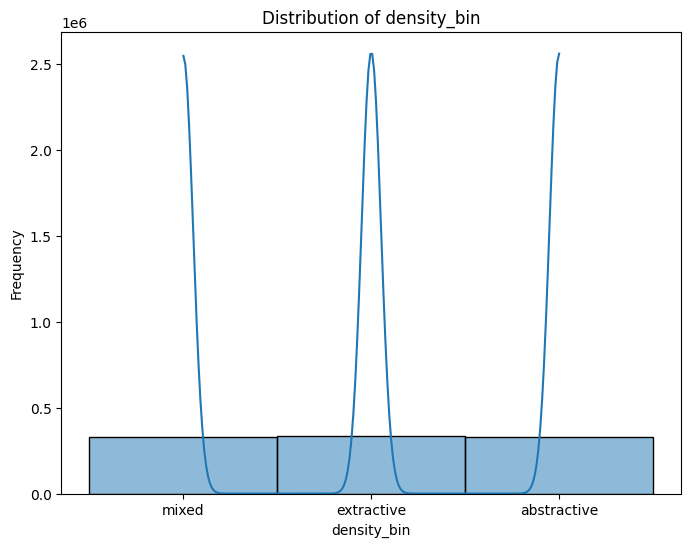

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your pandas DataFrame

# Loop through each column and create a distribution plot
for column in filtered_df.columns:
    plt.figure(figsize=(8, 6))  # Adjust figure size if needed
    sns.histplot(filtered_df[column], kde=True)  # Use histplot for distributions
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


In [ ]:
!pip install trl

In [ ]:
# prompt: I want to filtered the ds and test_ds with compression value less than 400

ds = dataset.filter(lambda x: x['compression'] < 400)
test_ds = test_dataset.filter(lambda x: x['compression'] < 400)

print("Filtered train dataset size:", len(ds['train']))
print("Filtered test dataset size:", len(test_ds['test']))

In [ ]:
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
import torch

from trl import PPOConfig, PPOTrainer, AutoModelForCausalLMWithValueHead
def map_bins(example):
    score_map = {'low': 0.0, 'medium': 2.0, 'high': 0.0}
    cov_map = {'low': 0.0, 'medium': 1.0, 'high': 2.0}

    density_map = {'extractive': 0.0, 'mixed': 1.0, 'abstractive': 2.0}
    example['compression_score'] = score_map[example['compression_bin']]
    example['coverage_score']    = cov_map[example['coverage_bin']]
    example['density_score']     = density_map[example['density_bin']]
    # Combined reward as the average
    example['reward_score']      = (
        example['compression_score'] +
        example['coverage_score']
        # +   example['density_score']
    ) / 2.0
    return example

def coverage_reward(example):
  example['reward_score'] = example['coverage'] * 2
  return example

def compression_reward(example):
  # normalize the compression value to 0-1
  compression_val = (example['compression'] - min_compression) / (max_compression - min_compression)
  example['reward_score'] = (compression_val) * 2
  return example

def density_reward(example):
  density_val = (example['density'] - min_density) / (max_density - min_density)
  example['reward_score'] = density_val * 2
  return example

# 1. Apply mapping to dataset
# ds = dataset.map(map_bins)
# test_ds = test_dataset.map(map_bins)

# ds = dataset.map(coverage_reward)
# test_ds = test_dataset.map(coverage_reward)

ds = ds.map(compression_reward)
test_ds = test_ds.map(compression_reward)

# ds = dataset.map(density_reward)
# test_ds = test_dataset.map(density_reward)


train_ds = ds



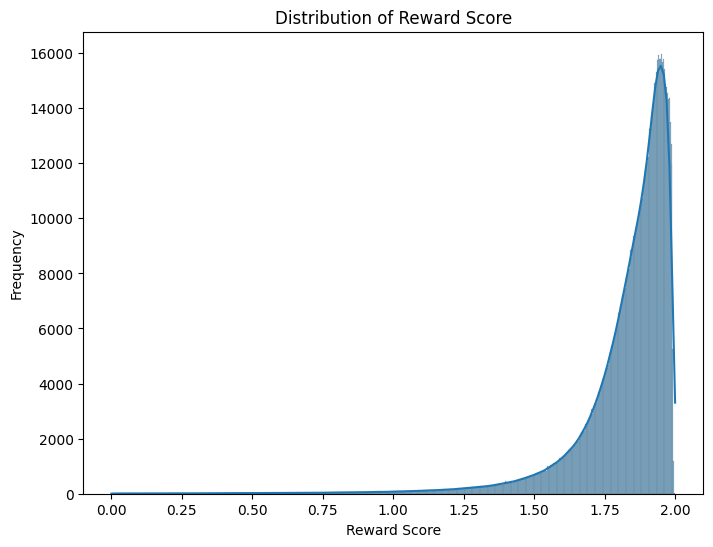

In [ ]:
# prompt: plot the reward_score distribution nwo

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.histplot(train_ds['train']['reward_score'], kde=True)
plt.title('Distribution of Reward Score')
plt.xlabel('Reward Score')
plt.ylabel('Frequency')
plt.show()

<h2> Reward Modelling </h2>



In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

# 4. Load tokenizer and model for regression
MODEL_NAME = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=1,
    problem_type='regression'
)

def preprocess(batch):
    # concatenate summary + text
    inputs = [s + tokenizer.sep_token + t for s, t in zip(batch['summary'], batch['text'])]
    enc = tokenizer(
        inputs,
        truncation=True,
        padding='max_length',
        max_length=512
    )
    enc['labels'] = batch['reward_score']
    return enc

train_enc = train_ds.map(preprocess, batched=True)
test_enc  = test_ds.map(preprocess,  batched=True)



In [ ]:
from transformers import TrainingArguments, Trainer
import wandb

wandb.init(
    project="compression-reward-model",  # your W&B project name
    name="compression-rwd-model-v1",         # a human‐friendly run name
    # config={
    #     "batch_size": 8,
    #     "lr": 5e-5,
    #     "epochs": 5,
    # }
)



training_args = TrainingArguments(
    output_dir="reward_model",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,


    # ------ step-based evaluation / saving / logging ------
    eval_strategy="steps",   # ← instead of "epoch"
    eval_steps=1000,                # run compute_metrics every 500 update steps
    save_strategy="steps",         # checkpoint every 500 steps as well
    save_steps=1000,
    logging_strategy="steps",      # write to the trainer logger every 100 steps
    logging_steps=100,

    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    learning_rate=5e-5,

    report_to=["wandb"],        # default is ["tensorboard"]
    #run_name="coverage-model-v1",     # matches wandb run name
)


def compute_metrics(eval_pred):
    preds, labels = eval_pred
    mse = ((preds.squeeze() - labels) ** 2).mean().item()
    return {"mse": mse}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_enc["train"],
    eval_dataset=test_enc["train"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model("reward_model")

In [ ]:


# 8. Integrate as reward model in RLHF with TRL PPO (Didnt had time to run)
# Load your policy (actor) model
actor_model = AutoModelForCausalLMWithValueHead.from_pretrained(MODEL_NAME)
reward_tokenizer = TRLTokenizer.from_pretrained(MODEL_NAME)

# PPO config
ppo_config = PPOConfig(
    model_name=MODEL_NAME,
    learning_rate=1.41e-5,
    batch_size=16,
    ppo_epochs=4
)

# Initialize PPO trainer
ppo_trainer = PPOTrainer(
    config=ppo_config,
    actor=actor_model,
    ref_model=actor_model,  # reference model for KL penalty
    tokenizer=reward_tokenizer,
    reward_model=model  # the trained reward model
)

# Example: one PPO step
texts = ["Text to summarize goes here."] * 4
for query in texts:
    # generate a batch of responses
    response_ids = ppo_trainer.generate(query, max_new_tokens=50)
    responses = [reward_tokenizer.decode(r, skip_special_tokens=True) for r in response_ids]
    # compute rewards
    rewards = ppo_trainer.reward_model(
        **reward_tokenizer(responses, [query]*len(responses), return_tensors="pt", padding=True, truncation=True)
    ).logits.squeeze().tolist()
    # run PPO step
    ppo_trainer.step(query, response_ids, rewards)